# Volume 3: ARMA Models

In [1]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.api import VARMAX
import statsmodels.api as sm
from statsmodels.tsa.stattools import arma_order_select_ic as order_select
import pandas as pd

## Helper Functions

In [2]:
def kalman(F, Q, H, time_series):
    # Get dimensions
    dim_states = F.shape[0]

    # Initialize variables
    # covs[i] = P_{i | i-1}
    covs = np.zeros((len(time_series), dim_states, dim_states))
    mus = np.zeros((len(time_series), dim_states))

    # Solve of for first mu and cov
    covs[0] = np.linalg.solve(np.eye(dim_states**2) - np.kron(F,F), 
            np.eye(dim_states**2) @ Q.flatten()).reshape((dim_states,dim_states))
    mus[0] = np.zeros((dim_states,))

    # Update Kalman Filter
    for i in range(1, len(time_series)):
        # Assume u, R = 0
        SkInv = np.linalg.solve(H @ covs[i-1] @ H.T, np.eye(H.shape[0]))
        Kk_H_Pkk = covs[i-1] @ (H.T @ (SkInv @ (H @ covs[i-1])))
        covs[i] = F @ ((covs[i-1] - Kk_H_Pkk) @ F.T) + Q
        mus[i] = F @ mus[i-1] + (F @ (covs[i-1] @ (H.T @ SkInv))) @ (time_series[i-1] - H @ mus[i-1])
    return mus, covs

def state_space_rep(phis, thetas, mu, sigma):
    # Initialize variables
    dim_states = max(len(phis), len(thetas)+1)
    dim_time_series = 1 #hardcoded for 1d time_series

    F = np.zeros((dim_states,dim_states))
    Q = np.zeros((dim_states, dim_states))
    H = np.zeros((dim_time_series, dim_states))

    # Create F
    F[0,:len(phis)] = phis
    F[1:,:-1] = np.eye(dim_states - 1)
    # Create Q
    Q[0][0] = sigma**2
    # Create H
    H[0][0] = 1.
    H[0][1:len(thetas)+1] = thetas

    return F, Q, H, dim_states, dim_time_series

## Naive Implementation

The function arma_forecast_naive() builds an ARMA(p,q) model to predict future values of a time series. The function takes parameters p (autoregressive order), q (moving average order), and n (number of predictions). The model assumes specific values for model parameters (ϕi = 0.5, θi = 0.1) and that the residuals (εi) follow a normal distribution with mean 0 and standard deviation 1.

To make the time series stationary, the function computes the first difference (np.diff()) of the input time series. This transformed series (zt) is then used for making predictions based on the ARMA model.

The function iterates through the ARMA model equation to forecast the next n observations. After computing the predictions, it plots the observed differences (zt) followed by the predicted values of zt.

Example usage includes applying this function to the temperature data stored in weather.npy, using specific ARMA parameters (p=2, q=1), and plotting the observed differences and predicted values.

In [34]:
def arma_forecast_naive(file='weather.npy',p=2,q=1,n=20):
    """
    Perform ARMA(p,q) on data. Let error terms be drawn from
    a standard normal, let c be 0, the phis be 0.5, and the 
    thetas be 0.1. Predict the next n observations and plot 
    the original data with the predictions.

    Parameters:
        file (str): data file
        p (int): order of autoregressive model
        q (int): order of moving average model
        n (int): number of future predictions
    """
    old = np.diff(np.load(file)).tolist()
    c = 0
    phi = 0.5
    theta = 0.1
    eps = np.random.normal(0,1,n)
    z = np.zeros(n)

    for i in range(n):
        ar = np.sum([phi * old[-(j+1)] for j in range(p)])
        ma = np.sum([theta * eps[-(j+1)] for j in range(q)])
        z[i] = c + ar + ma + eps[i]
        old = np.append(old, z[i])
    
    return z

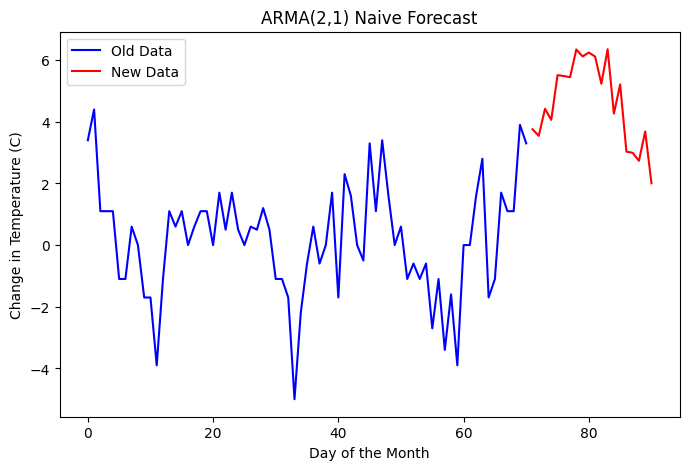

In [37]:
obs = arma_forecast_naive()
old = np.diff(np.load("weather.npy"))

# plot
plt.figure(figsize=(8,5))
plt.plot(np.arange(len(old)), old, label='Old Data', c="b")
plt.plot(np.arange(len(old), len(old)+len(obs)), obs, label='New Data', c="r")
plt.legend()
plt.xlabel("Day of the Month")
plt.ylabel("Change in Temperature (C)")
plt.title("ARMA(2,1) Naive Forecast")
plt.show()

## Likelihood

The function `arma_likelihood()` calculates the log-likelihood of an ARMA model given a time series of observations. It accepts a filename containing the observations and parameters representing the ARMA model (`Θ`). The time series used is the first difference of temperature data (`weather.npy`), which transforms the original time series into a stationary series.

The function computes and returns the log-likelihood of the ARMA(p, q) model as a floating-point value.

To assist in this calculation, the function uses the `state_space_rep()` function to generate matrices (`F`, `Q`, `H`) necessary for the state space representation of the ARMA model. Additionally, the provided `kalman()` function helps compute means (`xˆt|t−1`) and covariances (`Pt|t−1`) for each observation, which are used in likelihood computation.

In [50]:
def arma_likelihood(filename='weather.npy', phis=np.array([0.9]), thetas=np.array([0]), mu=17., std=0.4):
    """
    Transfer the ARMA model into state space.
    Return the log-likelihood of the ARMA model.

    Parameters:
        file (str): data file
        phis (ndarray): coefficients of autoregressive model
        thetas (ndarray): coefficients of moving average model
        mu (float): mean of errorm
        std (float): standard deviation of error

    Return:
        log_likelihood (float)
    """
    # get data
    time_series = np.diff(np.load(filename))

    # get state space representation
    F, Q, H, dim_states, dim_time_series = state_space_rep(phis, thetas, mu, std)

    # get Kalman Filter
    n = np.shape(time_series)[0]
    mus, covs = kalman(F, Q, H, time_series - np.ones(n)*mu)

    # return log-likelihood
    return np.sum([np.log(norm(H @ mus[i] + mu, np.sqrt(H @ covs[i] @ H.T)).pdf(time_series[i])) for i in range(len(mus))])

In [51]:
arma_likelihood(filename='weather.npy', phis=np.array([0.9]), thetas=np.array([0]), mu=17., std=0.4)

-1375.1805469978774

## Parameter Optimization

The function model_identification() accepts filename containing the time series data and parameters p_max and q_max as integers. It determines which ARMA(p, q) model has the minimum AIC for all 1 ≤ p ≤ p_max and 1 ≤ q ≤ q_max. It then returns each parameter in that model.


In [57]:
from scipy.optimize import minimize

def model_identification(filename='weather.npy',p_max=4,q_max=4):
    """
    Identify parameters to minimize AIC of ARMA(p,q) model

    Parameters:
        file (str): data file
        p_max (int): maximum order of autoregressive model
        q_max (int): maximum order of moving average model

    Returns:
        phis (ndarray (p,)): coefficients for AR(p)
        thetas (ndarray (q,)): coefficients for MA(q)
        mu (float): mean of error
        std (float): std of error
    """
    # assume p, q, and time_series are defined
    def f(x): # x contains the phis, thetas, mu, and std
        return -1*arma_likelihood(filename, phis=x[:p], thetas=x[p:p+q], mu=x[-2], std=x[-1])
    
    # get data
    time_series = np.diff(np.load(filename))
    n = len(time_series)

    # initialize optimization variables
    best_p = 0
    best_q = 0
    best_aic = np.inf
    best_sol = None

    # iterate through all possible p and q
    for p in range(1, p_max+1):
        print("p =", p, ", q =", end="")
        for q in range(1, q_max+1):
            # create initial point
            print(q, end=", ")
            x0 = np.zeros(p + q + 2)
            x0[-2] = time_series.mean()
            x0[-1] = time_series.std()
            sol = minimize(f, x0, method = "SLSQP")
            sol = sol['x']
            
            # compute AIC
            k = p + q + 2
            aic = 2*k*(1 + (k+1) / (n-k)) + 2*f(sol)

            # update best parameters
            if aic < best_aic:
                best_p = p
                best_q = q
                best_aic = aic
                best_sol = sol
        print()

    # run best model
    return best_sol[:best_p], best_sol[best_p:best_p+best_q], best_sol[-2], best_sol[-1]

In [58]:
model_identification(filename='weather.npy', p_max=4, q_max=4)

p =  1 , q = 1, 

/tmp/ipykernel_3931/1979342805.py:30: RuntimeWarning: invalid value encountered in sqrt
  return np.sum([np.log(norm(H @ mus[i] + mu, np.sqrt(H @ covs[i] @ H.T)).pdf(time_series[i])) for i in range(len(mus))])


2, 

/tmp/ipykernel_3931/1979342805.py:30: RuntimeWarning: divide by zero encountered in log
  return np.sum([np.log(norm(H @ mus[i] + mu, np.sqrt(H @ covs[i] @ H.T)).pdf(time_series[i])) for i in range(len(mus))])


3, 4, 
p =  2 , q = 1, 2, 3, 4, 
p =  3 , q = 1, 2, 3, 4, 
p =  4 , q = 1, 2, 3, 4, 


(array([0.72135383]),
 array([-0.26246423]),
 0.35978613877903526,
 1.5568375167857)

## Forecasting

The function arma_forecast() accepts filename containing a time series, the parameters for an ARMA model, and the number n of observations to forecast. 

It calculates the mean and covariance of the future n observations using the Kalman filter. To do this, we use state_space_rep() to generate F, Q, and H, then use kalman() (with µ subtracted off from the covariance stationary time series zk) to calculate xˆk|k−1 and Pk|k−1, respectively. We use the Update step on the last elements of zk (with µ subtracted off), xˆk|k−1, and Pk|k−1 to find xˆk|k and Pk|k. Then, we iteratively use the Predict step to make future predictions of the mean and covariance. 

We plot the original observations as well as the mean of each future observation. We also plot a 95% confidence interval (2 standard deviations away from the mean) around the means of future observations.

In [68]:
def arma_forecast(filename='weather.npy', phis=np.array([0]), thetas=np.array([0]), mu=0, std=0, n=30):
    """
    Forecast future observations of data.

    Parameters:
        file (str): data file
        phis (ndarray (p,)): coefficients of AR(p)
        thetas (ndarray (q,)): coefficients of MA(q)
        mu (float): mean of ARMA model
        std (float): standard deviation of ARMA model
        n (int): number of forecast observations
    """
    # get data
    z = np.diff(np.load(filename))

    # get state space representation
    F, Q, H, dim_states, dim_time_series = state_space_rep(phis, thetas, mu, std)

    # get Kalman Filter
    n = np.shape(z)[0]
    mus, covs = kalman(F, Q, H, z - np.ones(n)*mu)

    # update
    yt = z[-1] - H @ mus[-1]
    sk = H @ covs[-1] @ H.T
    kk = covs[-1] @ H.T @ np.linalg.inv(sk)
    x = mus[-1] + kk @ yt
    p = (np.eye(dim_states) - kk @ H) @ covs[-1]

    # set up predict
    mu1 = np.zeros(n + 1)
    cov1 = np.zeros(n + 1)
    mu1[0] = H @ mus[-1] + mu
    cov1[0] = H @ covs[-1] @ H.T
    
    # iteratively predict
    X, P = [x], [p]
    for t in range(n):
        X.append(F @ X[t])
        P.append(F @ P[t] @ F.T + Q)
        mu1[t+1] = H @ X[t + 1] + mu
        cov1[t+1] = H @ P[t + 1] @ H.T
    
    return mu1[1:], cov1[1:]

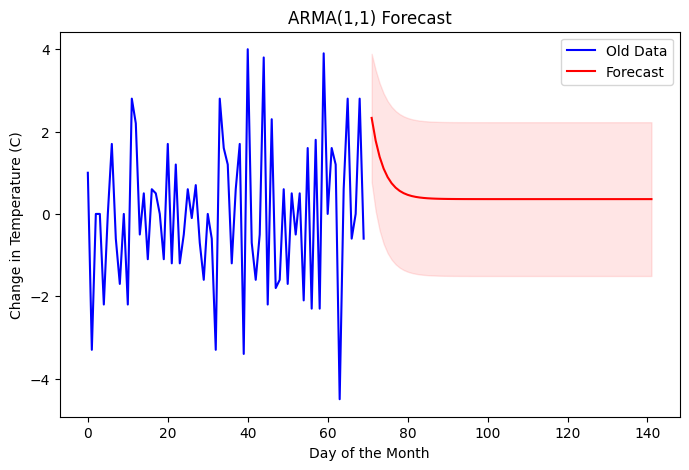

In [71]:
phis, thetas, mu, std = np.array([0.72135856]), np.array([-0.26246788]), 0.35980339870105321, 1.5568331253098422
mus, covs = arma_forecast(filename='weather.npy', phis=phis, thetas=thetas, mu=mu, std=std, n=30)

# set domains
old_domain = np.arange(len(old)-1)
new_domain = np.arange(len(old), len(old)+len(mus))

# plot
plt.figure(figsize=(8,5))
plt.plot(old_domain, np.diff(old), label='Old Data', c="b")
plt.plot(new_domain, mus, label='Forecast', c="r")
plt.fill_between(new_domain, mus - np.sqrt(covs), mus + np.sqrt(covs), color="r", alpha=0.1)
plt.legend()
plt.xlabel("Day of the Month")
plt.ylabel("Change in Temperature (C)")
plt.title("ARMA(1,1) Forecast")
plt.show()

This prediction is much more smooth than that of problem 1

## ARMA with statsmodels

The function sm_arma() accepts filename containing a time series, integer values for p_max and q_max, and the number n of values to predict.
It perform model identification to find the ARMA(p, q) model with the best AIC for 1 ≤ p ≤ p_max and 1 ≤ q ≤ q_max, but this time uses statsmodels. We use the optimal model to predict n future observations of the time series. We plot the original observations along with the predicted observations from the beginning through n observations in the future, as given by statsmodels. The function then returns the AIC of the optimal model.

In [86]:
def sm_arma(filename='weather.npy', p_max=3, q_max=3, n=30):
    """
    Build an ARMA model with statsmodel and
    predict future n values.

    Parameters:
        filename (str): data filename
        p_max (int): maximum order of autoregressive model
        q_max (int): maximum order of moving average model
        n (int): number of values to predict

    Return:
        aic (float): aic of optimal model
    """
    # get data
    z = np.diff(np.load(filename))
    k = len(z)

    # initialize optimization variables
    best_aic = np.inf
    best_model = None

    # iterate through all possible p and q
    for p in range(1, p_max+1):
        print("p = ", p, ", q = ", sep="", end="")
        for q in range(1, q_max+1):
            # create initial point
            print(q, end=", ")
            model = ARIMA(z,order=(p,0,q),trend='c').fit(method='innovations_mle')

            # update best parameters
            if model.aic < best_aic:
                best_aic = model.aic
                best_model = model
        print()

    # TODO get the 95% confidence interval of the best model
    conf = best_model.get_forecast(steps=k + n, alpha=0.05).conf_int()


    # run best model
    return best_model.predict(start=0, end=k+n-1), best_model.aic, conf

In [ ]:
predictions, aic, conf = sm_arma(filename='weather.npy', p_max=3, q_max=3, n=30)

<built-in function len>


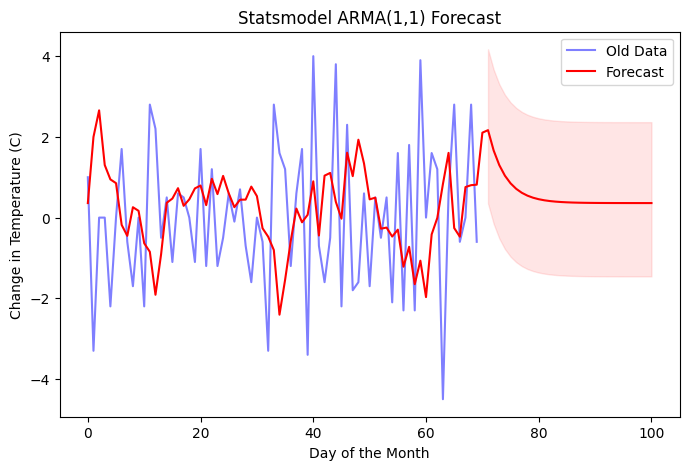

In [110]:
# set domains
old_domain = np.arange(len(old)-1)
new_domain = np.arange(len(predictions))
forecast_domain = np.arange(len(old), len(predictions))

# set confidence interval
lower = np.sqrt(-conf[:,0])[forecast_domain]
upper = np.sqrt(conf[:,1])[forecast_domain]
print(len)

# plot
plt.figure(figsize=(8,5))
plt.plot(old_domain, np.diff(old), label='Old Data', c="b", alpha=0.5)
plt.plot(new_domain, predictions, label='Forecast', c="r")
plt.fill_between(forecast_domain, predictions[forecast_domain] - lower, predictions[forecast_domain] + upper, color="r", alpha=0.1)
plt.legend()
plt.xlabel("Day of the Month")
plt.ylabel("Change in Temperature (C)")
plt.title("Statsmodel ARMA(1,1) Forecast")
plt.show()

## VARMAX

Thefunction sm_varma() accepts start and end dates for forecasting. We use the statsmodels VARMAX class to forecast on macroeconomic data between the start and end dates. We initialize the VARMAX model with the df specified above, and include the parameter freq="Q-DEC". We fit the model, and predict from the start date until the end date. We then get the model forecast until the end date. We plot the original data, prediction, and a 95% confidence interval (2 standard deviations away from the mean) around the future observations. Finally, we return the AIC of the chosen model.

In [119]:
def sm_varma(start='1959-09-30', end='2012-09-30'):
    """
    Build an VARMAX model with statsmodel and
    forecast from start date until end date.

    Parameters:
        start (str): the data at which to begin forecasting
        end (str): the date at which to stop forecasting

    Return:
        aic (float): aic of optimal model
    """
    # Load in data
    df = sm.datasets.macrodata.load_pandas().data
    # Create DatetimeIndex
    dates = df[['year', 'quarter']].astype(int).astype(str)
    dates = dates["year"] + "Q" + dates["quarter"]
    dates = dates_from_str(dates)
    df.index = pd.DatetimeIndex(dates)
    # Select columns used in prediction
    df = df[['realgdp','realcons','realinv']]

    v = VARMAX(df).fit(maxiter=1000, disp=False, ic='aic')
    pred = v.predict(start=start, end=end)
    forecast = v.get_forecast(end)
    conf = forecast.conf_int(alpha=0.05)

    # plot
    plt.figure(figsize=(8,8))
    plt.subplot(311)
    plt.plot(df.index, df['realgdp'], label='realgdp')
    plt.plot(pred.index, pred['realgdp'], label='realgdp forecast')
    plt.fill_between(conf.index, conf['lower realgdp'], conf['upper realgdp'], color='r', alpha=0.1)
    plt.legend()
    plt.xlabel("Year")
    plt.ylabel("Real GDP")
    plt.title("Real GDP Prediction")

    plt.subplot(312)
    plt.plot(df.index, df['realcons'], label='realcons')
    plt.plot(pred.index, pred['realcons'], label='realcons forecast')
    plt.fill_between(conf.index, conf['lower realcons'], conf['upper realcons'], color='r', alpha=0.1)
    plt.legend()
    plt.xlabel("Year")
    plt.ylabel("Real Consumption")
    plt.title("Real Consumption Prediction")

    plt.subplot(313)
    plt.plot(df.index, df['realinv'], label='realinv')
    plt.plot(pred.index, pred['realinv'], label='realinv forecast')
    plt.fill_between(conf.index, conf['lower realinv'], conf['upper realinv'], color='r', alpha=0.1)
    plt.legend()
    plt.xlabel("Year")
    plt.ylabel("Real Investment")
    plt.title("Real Investment Prediction")

    plt.suptitle("Problem 6")
    plt.tight_layout()
    plt.show()

    return v.aic

/home/dps2000/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/home/dps2000/.local/lib/python3.10/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ic. After release 0.14, this will raise.
  warnings.warn(


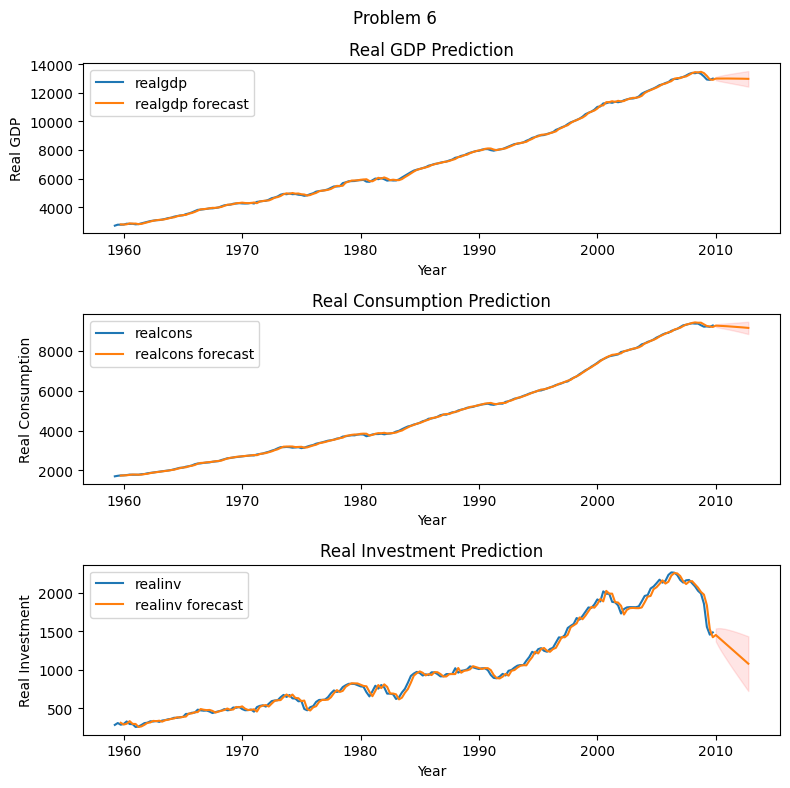

5973.228004727207

In [120]:
sm_varma()